In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

# To solve the problem of the minus sign '-' being displayed as a box
plt.rcParams['axes.unicode_minus'] = False 

### GDA

In [2]:
class GDA:
    # (GDA Class remains unchanged, included here for completeness)
    def __init__(self):
        self.phi = None
        self.mu0 = None
        self.mu1 = None
        self.sigma0 = None
        self.sigma1 = None

    def fit(self, X, y):
        n, d = X.shape
        self.phi = np.mean(y)
        self.mu0 = np.mean(X[y == 0], axis=0)
        self.mu1 = np.mean(X[y == 1], axis=0)
        self.sigma0 = np.cov(X[y == 0], rowvar=False)
        self.sigma1 = np.cov(X[y == 1], rowvar=False)

    def predict(self, X):
        scores = self.decision_function(X)
        return (scores > 0).astype(int)

    def _log_multivariate_gaussian_pdf(self, X, mu, sigma):
        d = X.shape[1]
        try:
            inv_sigma = np.linalg.inv(sigma)
            det_sigma = np.linalg.det(sigma)
            if det_sigma <= 0:
                det_sigma = 1e-12
        except np.linalg.LinAlgError:
            inv_sigma = np.linalg.inv(sigma + np.eye(d) * 1e-6)
            det_sigma = np.linalg.det(sigma + np.eye(d) * 1e-6)
        term1 = -0.5 * d * np.log(2 * np.pi)
        term2 = -0.5 * np.log(det_sigma)
        diff = X - mu
        term3 = -0.5 * np.einsum('ij,jk,ik->i', diff, inv_sigma, diff)
        return term1 + term2 + term3

    def decision_function(self, X):
        log_p_x_given_y0 = self._log_multivariate_gaussian_pdf(X, self.mu0, self.sigma0)
        log_p_x_given_y1 = self._log_multivariate_gaussian_pdf(X, self.mu1, self.sigma1)
        log_posterior0 = log_p_x_given_y0 + np.log(1 - self.phi)
        log_posterior1 = log_p_x_given_y1 + np.log(self.phi)
        return log_posterior1 - log_posterior0

In [3]:
def plot_decision_boundary(model, X, y, title):
    # (This function remains unchanged)
    plt.figure(figsize=(10, 8))
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='orange', marker='.', label='Taiwan Land (y=1)')
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='blue', marker='.', label='Sea (y=0)')
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    # (This function remains unchanged)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def run_gda_analysis(classification_file_path):
    print("--- Part 1: Gaussian Discriminant Analysis ---")
    
    try:
        clf_data = pd.read_csv(classification_file_path)
    except FileNotFoundError:
        print(f"Error: File not found '{classification_file_path}'. Please check the path.")
        return None, None, None # MODIFIED: Return an additional None
        
    X_clf = clf_data[['lon', 'lat']].values
    y_clf = clf_data['label'].values
    X_train, X_test, y_train, y_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)
    print(f"Dataset split -> Training set: {len(X_train)} samples, Test set: {len(X_test)} samples")

    gda_model = GDA()
    gda_model.fit(X_train, y_train)
    print("GDA model training complete.")
    
    y_pred = gda_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel accuracy on the test set: {accuracy:.4f}")

    print("\n--- (d) Performance Evaluation: Confusion Matrix ---")
    plot_confusion_matrix(y_test, y_pred, class_names=['Sea (0)', 'Land (1)'])

    plot_decision_boundary(gda_model, X_clf, y_clf, 'GDA Decision Boundary for Taiwan Classification')
    
    # MODIFIED: Return the clf_data DataFrame as well
    return gda_model, X_clf, clf_data

### Combined Piecewise Regression Model

In [5]:
# MODIFIED: Function signature now accepts classification_df
def run_regression_analysis(gda_model, X_clf_all, classification_df, regression_file_path):
    if gda_model is None:
        print("\nSkipping Part 2 because GDA model creation failed.")
        return

    print("\n--- Part 2: Combined Piecewise Regression Model ---")
    
    try:
        reg_data = pd.read_csv(regression_file_path)
    except FileNotFoundError:
        print(f"Error: File not found '{regression_file_path}'. Please check the path.")
        return
        
    X_reg = reg_data[['lon', 'lat']].values
    y_reg = reg_data['value'].values # Assume the column in the regression file is 'value'

    poly_features = PolynomialFeatures(degree=4, include_bias=False)
    X_poly = poly_features.fit_transform(X_reg)
    
    regression_model = LinearRegression()
    regression_model.fit(X_poly, y_reg)
    print("Linear regression model R(x) trained with 4th-degree polynomial features.")
    
    def h(X):
        classifications = gda_model.predict(X)
        X_poly_h = poly_features.transform(X)
        temperatures = regression_model.predict(X_poly_h)
        final_result = np.where(classifications == 1, temperatures, -999)
        return final_result

    print("\n--- (b) Piecewise Definition Verification ---")
    print("1. Verifying output for C(x) = 0 (Sea):")
    # From the classification data, find all points with true label = 0 (Sea)
    # This is our candidate pool; we expect most of these points to be predicted as 0
    all_sea_points_df = classification_df[classification_df['label'] == 0]
    all_sea_coords = all_sea_points_df[['lon', 'lat']].values

    # Let the GDA model C(x) predict on all these candidate points
    sea_predictions_by_C = gda_model.predict(all_sea_coords)

    # Now, select only those points that are actually predicted as 0 by the GDA model
    # These are the points we really need to verify
    points_predicted_as_sea_mask = (sea_predictions_by_C == 0)
    points_to_verify_coords = all_sea_coords[points_predicted_as_sea_mask]

    # From these points confirmed to be predicted as 0 by C(x), select 5
    # To ensure consistent results, we'll just take the first 5
    if len(points_to_verify_coords) >= 5:
        sample_coords_for_verification = points_to_verify_coords[:5]
    else:
        sample_coords_for_verification = points_to_verify_coords

    # Pass these points (confirmed to be predicted as 0 by C(x)) to h(x)
    verified_h_predictions = h(sample_coords_for_verification)

    # Create a DataFrame for clear presentation of results
    verification_df = pd.DataFrame({
        'Longitude (lon)': sample_coords_for_verification[:, 0],
        'Latitude (lat)': sample_coords_for_verification[:, 1],
        'h(x) Predicted Output': verified_h_predictions
    })
    print(verification_df.to_string(index=False))
    print("\nVerification successful: For points where C(x) predicts 0, h(x) correctly outputs -999.")

    print("\n2. Verifying regression performance for C(x) = 1 (Land) (True vs. Predicted Scatter Plot):")
    predicted_temperatures = h(X_reg)

    # This mask will be a boolean array, True where the predicted value is not -999
    mask = predicted_temperatures != -999

    # Use this mask to select the corresponding subsets of true and predicted values
    filtered_y_true = y_reg[mask]
    filtered_y_pred = predicted_temperatures[mask]

    plt.figure(figsize=(8, 8))
    plt.scatter(filtered_y_true, filtered_y_pred, alpha=0.6, label='Predicted Points (Filtered)')
    plt.plot([min(filtered_y_true), max(filtered_y_true)], 
             [min(filtered_y_true), max(filtered_y_true)], '--', color='red', label='Perfect Prediction Line (y=x)')
    plt.title('True vs. Predicted Scatter Plot (Showing only C(x)=1 predictions)')
    plt.xlabel('True Values (Temperature)')
    plt.ylabel('Predicted Values (Temperature)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

    print("Generating visualization for the combined model...")
    plt.figure(figsize=(12, 9))
    
    x_min, x_max = X_clf_all[:, 0].min() - 0.1, X_clf_all[:, 0].max() + 0.1
    y_min, y_max = X_clf_all[:, 1].min() - 0.1, X_clf_all[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z_h = h(grid_points)
    Z_h = Z_h.reshape(xx.shape)
    
    Z_masked = np.ma.masked_where(Z_h == -999, Z_h)
    plt.imshow(np.zeros_like(Z_h), extent=[x_min, x_max, y_min, y_max], origin='lower', cmap='Blues', alpha=0.5)
    contour = plt.contourf(xx, yy, Z_masked, levels=20, cmap='viridis', alpha=0.9)
    plt.colorbar(contour, label='Predicted Temperature (°C)')

    Z_gda_boundary = gda_model.decision_function(grid_points)
    Z_gda_boundary = Z_gda_boundary.reshape(xx.shape)
    
    plt.contour(
        xx, yy, Z_gda_boundary, 
        levels=[0],
        colors='red',
        linewidths=2,
        linestyles='--'
    )

    plt.scatter(X_reg[:, 0], X_reg[:, 1], c=y_reg, cmap='viridis', edgecolor='k', s=20, label='Actual Temperature Points')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Behavior of Combined Model h(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

--- Part 1: Gaussian Discriminant Analysis ---
Dataset split -> Training set: 6432 samples, Test set: 1608 samples
GDA model training complete.

Model accuracy on the test set: 0.8526

--- (d) Performance Evaluation: Confusion Matrix ---


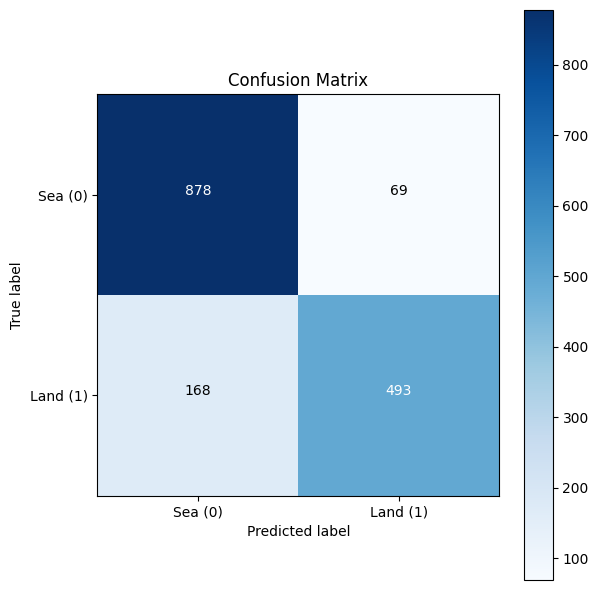

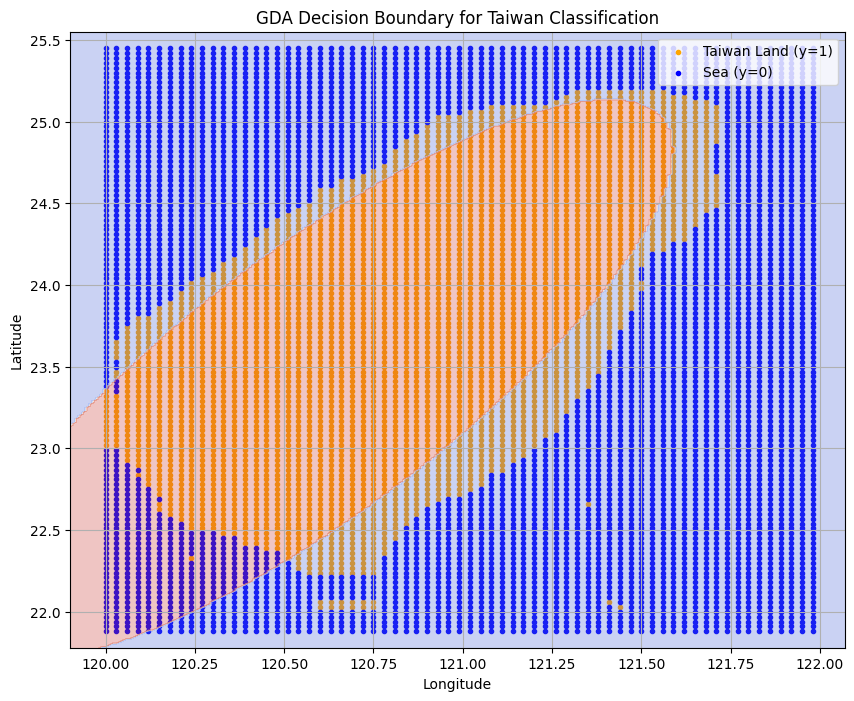


--- Part 2: Combined Piecewise Regression Model ---
Linear regression model R(x) trained with 4th-degree polynomial features.

--- (b) Piecewise Definition Verification ---
1. Verifying output for C(x) = 0 (Sea):
 Longitude (lon)  Latitude (lat)  h(x) Predicted Output
          120.12           21.88                 -999.0
          120.15           21.88                 -999.0
          120.18           21.88                 -999.0
          120.21           21.88                 -999.0
          120.24           21.88                 -999.0

Verification successful: For points where C(x) predicts 0, h(x) correctly outputs -999.

2. Verifying regression performance for C(x) = 1 (Land) (True vs. Predicted Scatter Plot):


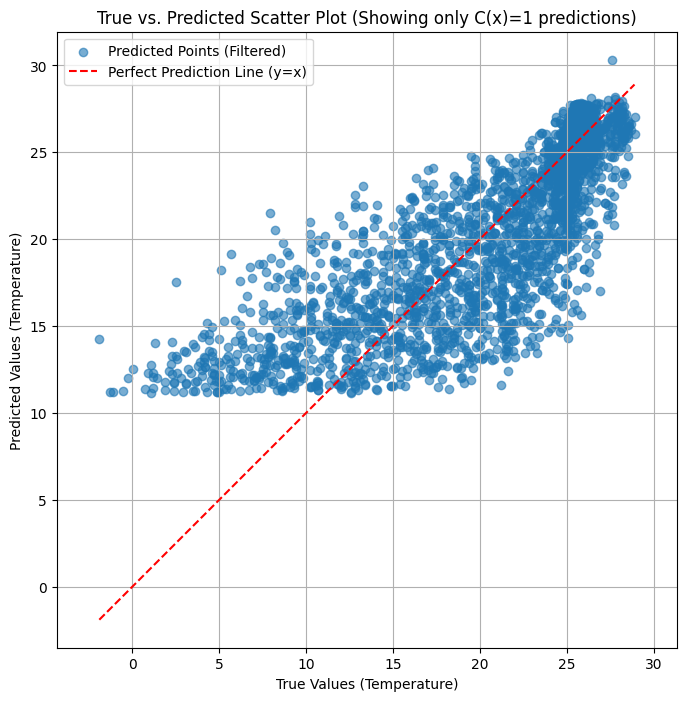

Generating visualization for the combined model...


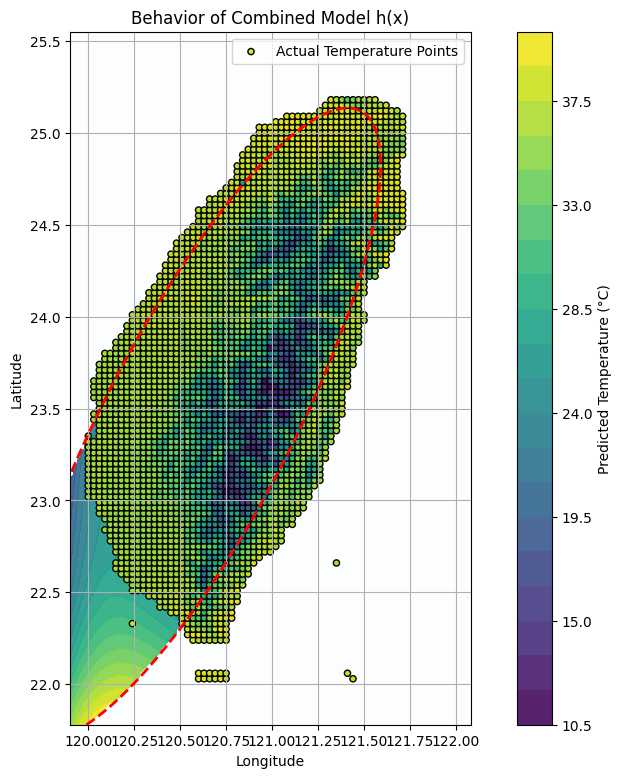

In [6]:
if __name__ == '__main__':
    classification_file_path = r"C:\hsiang\machine learning\2025_machine_learning\Week_6\classification_clean.csv"
    regression_file_path = r"C:\hsiang\machine learning\2025_machine_learning\Week_6\regression_clean.csv"
    
    # MODIFIED: Receive the three return values from run_gda_analysis
    trained_gda_model, all_clf_data, classification_df = run_gda_analysis(classification_file_path)
    
    # MODIFIED: Pass classification_df to run_regression_analysis
    run_regression_analysis(trained_gda_model, all_clf_data, classification_df, regression_file_path)